In [12]:
import numpy as np
import os, sys
import galsim as gs
from galsim.angle import Angle, radians
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import colors

tk_path = '/Users/sweveret/repos/kl-tools/kl_tools'
sys.path.insert(0, tk_path)
from velocity import VelocityMap
import transformation as transform
import likelihood, cube, priors, utils, basis

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [8]:
true_pars = {
    'g1': 0.05,
    'g2': -0.025,
    'theta_int': np.pi / 3,
    'sini': 0.8,
    'v0': 10.,
    'vcirc': 200,
    'rscale': 5,
}

# additional args needed for prior / likelihood evaluation
halpha = 656.28 # nm
R = 5000.
z = 0.3
pars = {
    'Nx': 30, # pixels
    'Ny': 30, # pixels
    'pix_scale': 1., # arcsec / pixel
    'true_flux': 1e5, # counts
    'true_hlr': 5, # pixels
    'v_unit': u.Unit('km / s'),
    'r_unit': u.Unit('kpc'),
    'z': z,
    'spec_resolution': R,
    'line_std': halpha * (1.+z) / R, # emission line SED std; nm
    'line_value': 656.28, # emission line SED std; nm
    'line_unit': u.Unit('nm'),
    'sed_start': 655,
    'sed_end': 657.5,
    'sed_resolution': 0.025,
    'sed_unit': u.Unit('nm'),
    'cov_sigma': 3, # pixel counts; dummy value
    'bandpass_throughput': '.2',
    'bandpass_unit': 'nm',
    'bandpass_zp': 30,
    'priors': {
        'g1': priors.GaussPrior(0., 0.3),#, clip_sigmas=2),
        'g2': priors.GaussPrior(0., 0.3),#, clip_sigmas=2),
        'theta_int': priors.UniformPrior(0., np.pi),
        'sini': priors.UniformPrior(0., 1.),
        'v0': priors.UniformPrior(0, 20),
        'vcirc': priors.GaussPrior(200, 10, zero_boundary='positive'),# clip_sigmas=2),
        'rscale': priors.UniformPrior(0, 10),
    },
    'intensity': {
        # For this test, use truth info
        # 'type': 'inclined_exp',
        # 'flux': 1e5, # counts
        # 'hlr': 5, # pixels
        'type': 'basis',
        'basis_type': 'sersiclets',
        'basis_kwargs': {
            'Nmax': 3,
            'plane': 'obs',
            'index': 1,
            'b': 1
            }
    },
    # 'marginalize_intensity': True,
    # 'psf': gs.Gaussian(fwhm=3), # fwhm in pixels
    'use_numba': False,
}

In [4]:
# make datavector
li, le, dl = 655.8, 656.8, 0.1
lambdas = [(l, l+dl) for l in np.arange(li, le, dl)]

bandpasses = cube.setup_simple_bandpasses(
    li, le, dl,
    throughput=pars['bandpass_throughput'],
    zp=pars['bandpass_zp'],
    unit=pars['bandpass_unit']
    )

Nx, Ny = 30, 30
Nspec = len(lambdas)
shape = (Nx, Ny, Nspec)
print('Setting up test datacube and true Halpha image')
datacube, sed, vmap, true_im = likelihood.setup_likelihood_test(
    true_pars, pars, shape, lambdas
    )

Setting up test datacube and true Halpha image


In [14]:
def make_basis_imap(theta_pars, datacube, pars):
    imap = likelihood._setup_imap(theta_pars, datacube, pars)
    i = imap.render(theta_pars, datacube, pars)
    marg = imap.fitter.compute_marginalization_det(pars=pars, log=True)
    mle = imap.fitter.mle_coefficients
    
    return i, marg, mle

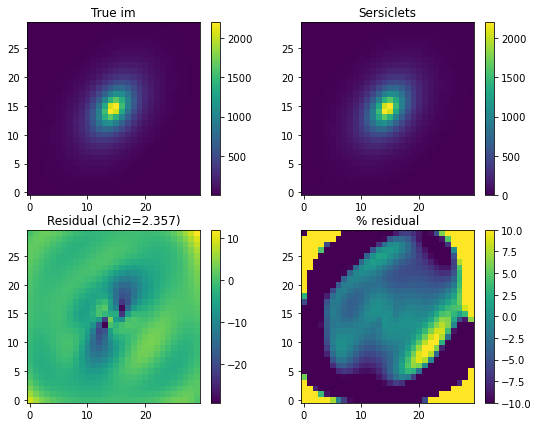

In [74]:
pars['intensity']['basis_kwargs']['Nmax'] = 5
pars['intensity']['basis_kwargs']['plane'] = 'disk'
pars['intensity']['basis_kwargs']['b'] = 1

imap, marg, mle = make_basis_imap(true_pars, datacube, pars)

plt.subplot(221)
plt.imshow(true_im, origin='lower')
plt.colorbar()
plt.title('True im')

plt.subplot(222)
plt.imshow(imap, origin='lower')
plt.colorbar()
plt.title('Sersiclets')

plt.subplot(223)
resid = imap - true_im
plt.imshow(resid, origin='lower')
plt.colorbar()
sig = pars['cov_sigma']
chi2 = np.sum((resid/sig)**2) / (Nx*Ny)
plt.title(f'Residual (chi2={chi2:.3f})')

plt.subplot(224)
vmin, vmax = -10, 10
plt.imshow(100.*resid/true_im, origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('% residual')

plt.gcf().set_size_inches(9,7)